# Install Dependencies

In [6]:
!pip install tensorflow==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [7]:
!pip install tensorflow-gpu==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [9]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


# Import Dependencies

In [10]:
#importing standard dependencies

import cv2
import os
import random
import time
import numpy as np
import requests
from matplotlib import pyplot as plt

In [11]:
#imporing tensorflow dependencies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


# Set GPU Growth

#### This is to avoid the out of memory error and limit the GPU usage
#### If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device.

In [12]:
#check the number of available GPU and also check if tensorflow is detecting it
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [13]:
#getting the details of the GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13691555610568838426
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13273130564688437272
 physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [14]:
#setting memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Create folder structure

In [15]:
import tempfile

temp_dir = tempfile.gettempdir() # retrieves the system's temporary directory

temp_dir

'C:\\Users\\utsav\\AppData\\Local\\Temp'

In [55]:
# Setup paths in temp dir
POS_PATH = os.path.join(temp_dir,'data', 'positive')
NEG_PATH = os.path.join(temp_dir,'data', 'negative')
ANC_PATH = os.path.join(temp_dir,'data', 'anchor')
CHEKPOINT_PATH = os.path.join(temp_dir,'data', 'training_checkpoints')

print("Positive path: ",POS_PATH)
print("Negative path: ",NEG_PATH)
print("Anchor path: ",ANC_PATH)

Positive path:  C:\Users\utsav\AppData\Local\Temp\data\positive
Negative path:  C:\Users\utsav\AppData\Local\Temp\data\negative
Anchor path:  C:\Users\utsav\AppData\Local\Temp\data\anchor


In [17]:

# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)

# Collect Positives,Negatives and Anchors

#### Negatives collection from existing dataset

In [18]:
from urllib import request

url = "https://figshare.com/ndownloader/files/5976018/lfw.tgz"
target_path = os.path.join(NEG_PATH,"lfw.tgz")

with request.urlopen(request.Request(url), timeout=15.0) as response:
    if response.status == 200:
        with open(target_path, "wb") as f:
            f.write(response.read())

In [19]:
import tarfile

def uncompress_tar(tar_filepath, extract_path):
    try:
        with tarfile.open(tar_filepath, 'r') as tar:
            tar.extractall(path=extract_path)
        print(f"Successfully extracted '{tar_filepath}' to '{extract_path}'")
    except FileNotFoundError:
        print(f"Error: Tar file '{tar_filepath}' not found.")
    except tarfile.ReadError as e:
         print(f"Error: Could not open '{tar_filepath}'. It may be corrupted or not a valid tar file. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [20]:
uncompress_tar(target_path,NEG_PATH)

Successfully extracted 'C:\Users\utsav\AppData\Local\Temp\data\negative\lfw.tgz' to 'C:\Users\utsav\AppData\Local\Temp\data\negative'


In [21]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir(os.path.join(NEG_PATH,"lfw")):
    for file in os.listdir(os.path.join(os.path.join(NEG_PATH,"lfw"), directory)):
        EX_PATH = os.path.join(os.path.join(NEG_PATH,"lfw"), directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [22]:
import shutil
# removing the tar and extracted folder from NEG_PATh
os.remove(target_path)
shutil.rmtree(os.path.join(NEG_PATH,"lfw"))

#### Positive collection from webcam

In [23]:
# importing uuid library to geenrate unique image names
import uuid

In [24]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 30

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

#### Anchor collection from webcam

In [25]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 30

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

# Data Augmentation

In [26]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [27]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [28]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Images

#### Get images directories

In [29]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [30]:
dir_test = anchor.as_numpy_iterator()

In [31]:
#to check if the iterator is reading all the imaage path
print(dir_test.next())

b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\anchor\\5004c67e-3791-11f0-9c14-c423607b4a5c.jpg'


#### Preprocessing - Scale and Resize

In [32]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [33]:
img = preprocess(dir_test.next())

In [34]:
img.numpy()

array([[[0.5272059 , 0.54289216, 0.4879902 ],
        [0.5264706 , 0.5411765 , 0.48921567],
        [0.52867645, 0.54044116, 0.49730393],
        ...,
        [0.56078434, 0.55588233, 0.50392157],
        [0.57965684, 0.58210784, 0.5323529 ],
        [0.577451  , 0.5852941 , 0.53431374]],

       [[0.51936275, 0.5370098 , 0.48406863],
        [0.52916664, 0.54607844, 0.49534315],
        [0.5237745 , 0.5362745 , 0.49289215],
        ...,
        [0.55      , 0.54019606, 0.49044117],
        [0.58235294, 0.5745098 , 0.5267157 ],
        [0.5764706 , 0.5764706 , 0.5294118 ]],

       [[0.51593137, 0.5394608 , 0.49240196],
        [0.5154412 , 0.5367647 , 0.49044117],
        [0.5242647 , 0.5367647 , 0.49338236],
        ...,
        [0.55441177, 0.53431374, 0.4882353 ],
        [0.5803922 , 0.57058823, 0.5245098 ],
        [0.5754902 , 0.56666666, 0.52843136]],

       ...,

       [[0.37941176, 0.422549  , 0.3990196 ],
        [0.3735294 , 0.4245098 , 0.3970588 ],
        [0.3745098 , 0

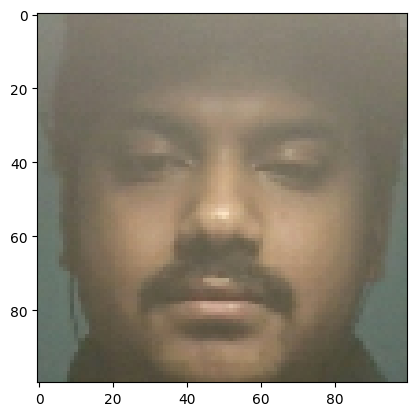

In [35]:
#to check the scaling is working. We will see the image size should be 100x100px
plt.imshow(img)

#### Create Labelled Dataset

In [36]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [37]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [38]:
samples = data.as_numpy_iterator()

In [39]:
example = samples.next()

In [40]:
example

(b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\anchor\\6935fa25-3791-11f0-855f-c423607b4a5c.jpg',
 b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\positive\\b5765d0d-3791-11f0-b806-c423607b4a5c.jpg',
 1.0)

#### Build Train and Test Partition

In [41]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [42]:
res = preprocess_twin(*example)

In [43]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.64117646, 0.6764706 , 0.6098039 ],
         [0.6497549 , 0.66495097, 0.6110294 ],
         [0.6617647 , 0.6637255 , 0.6156863 ],
         ...,
         [0.6022059 , 0.59044117, 0.55514705],
         [0.5982843 , 0.5865196 , 0.5512255 ],
         [0.577451  , 0.577451  , 0.5382353 ]],
 
        [[0.64215684, 0.6637255 , 0.60882354],
         [0.6519608 , 0.66568625, 0.6122549 ],
         [0.6504902 , 0.6497549 , 0.60906863],
         ...,
         [0.5860294 , 0.5801471 , 0.53382355],
         [0.5973039 , 0.5894608 , 0.5485294 ],
         [0.5862745 , 0.58431375, 0.5414216 ]],
 
        [[0.6401961 , 0.65      , 0.5980392 ],
         [0.6490196 , 0.654902  , 0.6112745 ],
         [0.654902  , 0.6460784 , 0.6142157 ],
         ...,
         [0.56666666, 0.57058823, 0.50980395],
         [0.57034314, 0.56764704, 0.5090686 ],
         [0.5852941 , 0.577451  , 0.5205882 ]],
 
        ...,
 
        [[0.4360294 , 0.5144608 

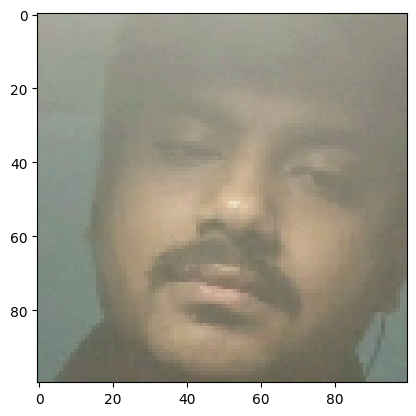

In [44]:
plt.imshow(res[0])

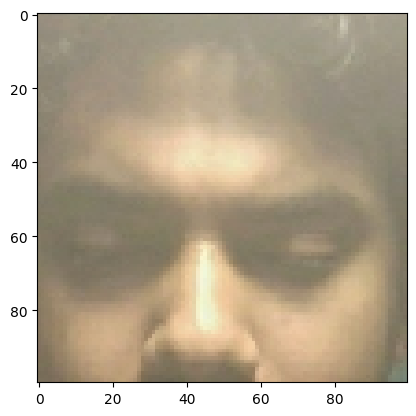

In [45]:
plt.imshow(res[1])

In [73]:
preprocess_twin

<function __main__.preprocess_twin(input_img, validation_img, label)>

In [46]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [74]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [47]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [56]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

#### Build Embedding Layer

In [57]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [58]:
embedding = make_embedding()

In [59]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

#### Build Distance Layer

In [60]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

#### Make Siamese Model

In [61]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [62]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

#### Setup Loss and Optimizer

In [63]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [64]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

#### Establish Checkpoints

In [65]:
checkpoint_dir = CHEKPOINT_PATH
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

#### Build Train Step Function

In [66]:
test_batch = train_data.as_numpy_iterator()

In [67]:
batch_1 = test_batch.next()

In [68]:
X = batch_1[:2]

In [69]:
X

(array([[[[0.55196077, 0.57941175, 0.51666665],
          [0.55490196, 0.57941175, 0.5176471 ],
          [0.5568628 , 0.57254905, 0.5137255 ],
          ...,
          [0.6132353 , 0.62058824, 0.56985295],
          [0.6139706 , 0.6125    , 0.5654412 ],
          [0.6122549 , 0.60588235, 0.5588235 ]],
 
         [[0.55490196, 0.5686275 , 0.5107843 ],
          [0.5588235 , 0.57254905, 0.5147059 ],
          [0.5512255 , 0.564951  , 0.50710785],
          ...,
          [0.59705883, 0.61470586, 0.5598039 ],
          [0.60563725, 0.62328434, 0.5683824 ],
          [0.6068627 , 0.6166667 , 0.5647059 ]],
 
         [[0.55490196, 0.5598039 , 0.50490195],
          [0.5647059 , 0.56960785, 0.5147059 ],
          [0.55490196, 0.55759805, 0.50710785],
          ...,
          [0.5926471 , 0.6154412 , 0.56642157],
          [0.60490197, 0.61960787, 0.5735294 ],
          [0.60490197, 0.61764705, 0.5715686 ]],
 
         ...,
 
         [[0.3997549 , 0.46053922, 0.43259802],
          [0.41617

In [70]:
y = batch_1[2]

In [71]:
y

array([1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
      dtype=float32)

In [72]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

#### Build Training Loop

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

#### Train the model